# Lending Club Case Study

## Table of Contents

1. [Business Understanding](#business-understanding)
2. [Importing Libraries](#importing-all-the-libraries-and-enabling-common-settings)
3. [Common Functions](#common-functions)
4. [Data Understanding](#data-understanding)
    1. [Importing Data](#importing-data)
    2. [Data Info](#data-info)
5. [Data Filtering](#data-filtering)
6. [Data Cleaning](#data-cleaning)
    1. [Remove Empty Rows](#remove-empty-rows)
    2. [Remove Empty Columns](#remove-empty-columns)
    3. [Remove Unwanted Columns](#remove-columns-having-majority-values-as-nulls)
    4. [Data Imputation](#data-imputation)
    5. [Data Conversion](#data-conversion)
7. [Data Analysis](#data-analysis)


## Business Understanding
Lenden Club is a consumer finance company that specialises in lending various types of loans to urban customers. When the company receives a loan application, the company has to make a decision for loan approval based on the applicant’s profile. Two types of risks are associated with the bank’s decision:
-  If the applicant is likely to repay the loan, then not approving the loan results in a loss of business to the company
-  If the applicant is not likely to repay the loan, i.e. he/she is likely to default, then approving the loan may lead to a financial loss for the company
 
The provided dataset contains information about past loan applicants and whether they ‘defaulted’ or not. The aim is to identify patterns which indicate if a person is likely to default, which may be used for taking actions such as denying the loan, reducing the amount of loan, lending (to risky applicants) at a higher interest rate, etc.

When a person applies for a loan, there are two types of decisions that could be taken by the company:
1. Loan accepted: If the company approves the loan, there are 3 possible scenarios described below:
    -   Fully paid: Applicant has fully paid the loan (the principal and the interest rate)
    -   Current: Applicant is in the process of paying the instalments, i.e. the tenure of the loan is not yet completed. These candidates are not labelled as 'defaulted'.
    -   Charged-off: Applicant has not paid the instalments in due time for a long period of time, i.e. he/she has defaulted on the loan 
2. Loan rejected: The company had rejected the loan (because the candidate does not meet their requirements etc.). Since the loan was rejected, there is no transactional history of those applicants with the company and so this data is not available with the company (and thus in this dataset)

## Importing all the libraries and enabling common settings

In [1]:
import numpy as np # math library
import pandas as pd # to work with datasets
import matplotlib.pyplot as plt # used for plotting simple 2D graphs
import seaborn as sns # visualization library based on matplotlib
import re # library to work on string manipulation
import warnings # library to show warning messages

import plotly.offline as py 
py.init_notebook_mode(connected=True) # this code, allow us to work with offline plotly version
import plotly.graph_objs as go # it's like "plt" of matplot
import plotly.tools as tls # It's useful to we get some tools of plotly
import warnings # This library will be used to ignore some warnings
from collections import Counter # To do counter of some features

# pandas settings
pd.options.display.float_format = '{:.2f}'.format # sometimes numbers can show up in scientific format. using this option will show numbers in flot format with 2 decimals
pd.options.display.max_columns = None # remove limitations on number of columns

# we can ignore warnings that arise because of versions
warnings.filterwarnings('ignore')
input_file = 'loan.csv'

## Common Functions

In [2]:
def missing_value_percentage(input_df):
    """
    purpose: to create a df that will contain all columns with the percentage of missing values
    input: DataFrame
    output: DataFrame
    """
    missing_count = input_df.isnull().sum()
    percent_missing = missing_count * 100 / len(input_df)
    missing_value_df = pd.DataFrame({'column_name': input_df.columns,
                                     'missing_count': missing_count,
                                 'percent_missing': percent_missing})
    # print(missing_value_df)
    return missing_value_df

def removeOutliers(data, col):
    Q3 = np.quantile(data[col], 0.75)
    Q1 = np.quantile(data[col], 0.25)
    IQR = Q3 - Q1
 
    print("IQR value for column %s is: %s" % (col, IQR))
    global outlier_free_list
    global filtered_data
 
    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR
    outlier_free_list = [x for x in data[col] if (
        (x > lower_range) & (x < upper_range))]
    filtered_data = data.loc[data[col].isin(outlier_free_list)]
 
 
    for i in data.columns:
        if i == data.columns[0]:
            removeOutliers(data, i)
    else:
        removeOutliers(filtered_data, i)

def plot_with_target_variable(df, col, target_col):
    x, y, hue = col, "proportion", target_col

    (df[x]
    .groupby(df[hue])
    .value_counts(normalize=True)
    .rename(y)
    .reset_index()
    .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

## Data Understanding

### Importing Data

In [3]:
loan_df = pd.read_csv(input_file) # reading the input loan csv file
loan_df.head() # checking the initial 5 rows

# Observations:
# data seems to have got imported without any errors

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.00,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.00,Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0,Jan-85,1,NaN,NaN,3,0,13648,83.70%,9,f,0.00,0.00,5863.16,5833.84,5000.00,863.16,0.00,0.00,0.00,Jan-15,171.62,NaN,May-16,0.00,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.00,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.00,Source Verified,Dec-11,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0,Apr-99,5,NaN,NaN,3,0,1687,9.40%,4,f,0.00,0.00,1008.71,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.00,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.00,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.00,Not Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,8.72,0,Nov-01,2,NaN,NaN,2,0,2956,98.50%,10,f,0.00,0.00,3005.67,3005.67,2400.00,605.67,0.00,0.00,0.00,Jun-14,649.91,NaN,May-16,0.00,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.00,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.00,Source Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0,Feb-96,1,35.00,NaN,10,0,5598,21%,37,f,0.00,0.00,12231.89,12231.89,10000.00,2214.92,16.97,0.00,0.00,Jan-15,357.48,NaN,Apr-16,0.00,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

### Data Info

In [4]:
print(loan_df.shape) #shows the column and row count
print(loan_df.info(verbose = True,show_counts = True)) # shows not null counts and data type of all columns
loan_df.describe(include='all') # provided summary statistics of all columns

# Observations:
# dataset contains 39717 rows and 111 columns
# there seems to be a lot of columns with empty values - these can be ignored 

(39717, 111)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 111 columns):
 #    Column                          Non-Null Count  Dtype  
---   ------                          --------------  -----  
 0    id                              39717 non-null  int64  
 1    member_id                       39717 non-null  int64  
 2    loan_amnt                       39717 non-null  int64  
 3    funded_amnt                     39717 non-null  int64  
 4    funded_amnt_inv                 39717 non-null  float64
 5    term                            39717 non-null  object 
 6    int_rate                        39717 non-null  object 
 7    installment                     39717 non-null  float64
 8    grade                           39717 non-null  object 
 9    sub_grade                       39717 non-null  object 
 10   emp_title                       37258 non-null  object 
 11   emp_length                      38642 non-null  object 
 12   hom

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,39717.00,39717.00,39717.00,39717.00,39717.00,39717,39717,39717.00,39717,39717,37258,38642,39717,39717.00,39717,39717,39717,39717,39717,26777,39717,39706,39717,39717,39717.00,39717.00,39717,39717.00,14035.00,2786.00,39717.00,39717.00,39717.00,39667,39717.00,39717,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39646,39717.00,1140,39715,39661.00,0.00,39717.00,39717,0.00,0.00,0.00,39717.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,39661.00,39717.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,39020.00,39678.00,0.00,0.00,0.00,0.00
unique,NaN,NaN,NaN,NaN,NaN,2,371,NaN,7,35,28820,11,5,NaN,3,55,3,1,39717,26527,14,19615,823,50,NaN,NaN,526,NaN,NaN,NaN,NaN,NaN,NaN,1089,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101,NaN,2,106,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,36 months,10.99%,NaN,B,B3,US Army,10+ years,RENT,NaN,Not Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,,debt_consolidation,Debt Consolidation,100xx,CA,NaN,NaN,Nov-98,NaN,NaN,NaN,NaN,NaN,NaN,0%,NaN,f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,May-16,NaN,Jun-16,May-16,NaN,NaN,NaN,INDIVIDUAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,29096,956,NaN,12020,2917,134,8879,18899,NaN,16921,2260,32950,39717,1,210,18641,2184,597,7099,NaN,NaN,370,NaN,NaN,NaN,NaN,NaN,NaN,977,NaN,39717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1256,NaN,1125,10308,NaN,NaN,NaN,39717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,683131.91,850463.56,11219.44,10947.71,10397.45,NaN,NaN,324.56,NaN,NaN,NaN,NaN,NaN,68968.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.32,0.15,NaN,0.87,35.90,69.70,9.29,0.06,13382.53,NaN,22.09,NaN,51.23,50.99,12153.60,11

## Data Filtering

In [5]:
# checking different loan statuses
print(loan_df.loan_status.value_counts())

# Observations:
# There are three types of loan_statuses
# 1. Fully Paid - customers have fully paid the loan
# 2. Charged Off - customers have defaulted
# 3. Current - on-going loans 


Fully Paid     32950
Charged Off     5627
Current         1140
Name: loan_status, dtype: int64


In [6]:
# based on the problem statement we only need to consider fully paid (or non defaulters) and charged off (defaulters) customers.
# filtering the data in the beginning of the process, helps us process the data faster 

loan_status_to_consider = ['Fully Paid','Charged Off'] 
loan_df = loan_df[loan_df.loan_status.isin(loan_status_to_consider)]
print(loan_df.loan_status.value_counts())
print(loan_df.shape) 

# Observations:
# 1. Loan dataframe has only fully paid and charged off customers
# 2. Number of rows has reduced from 39717 to 38577 - although the size reduction is not much, in generall filtering the data before doing 
# anything else helps.

Fully Paid     32950
Charged Off     5627
Name: loan_status, dtype: int64
(38577, 111)


## Data Cleaning

### Remove empty rows


In [7]:
loan_df = loan_df.dropna(how='all', axis=0) # dropna removes empty rows or cols based on config
print(loan_df.shape) 

# Observations:
# There are no empty rows

(38577, 111)


### Remove empty columns

In [8]:
loan_df = loan_df.dropna(how='all', axis=1) # dropna removes empty rows or cols based on config
print(loan_df.shape) 
loan_df.head()

# Observations:
# 55 columns were dropped as they were completely empty

(38577, 56)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,1077501,1296599,5000,5000,4975.00,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.00,Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0,Jan-85,1,NaN,NaN,3,0,13648,83.70%,9,f,0.00,0.00,5863.16,5833.84,5000.00,863.16,0.00,0.00,0.00,Jan-15,171.62,May-16,0.00,1,INDIVIDUAL,0,0.00,0,0.00,0.00
1,1077430,1314167,2500,2500,2500.00,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.00,Source Verified,Dec-11,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0,Apr-99,5,NaN,NaN,3,0,1687,9.40%,4,f,0.00,0.00,1008.71,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,Sep-13,0.00,1,INDIVIDUAL,0,0.00,0,0.00,0.00
2,1077175,1313524,2400,2400,2400.00,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.00,Not Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,8.72,0,Nov-01,2,NaN,NaN,2,0,2956,98.50%,10,f,0.00,0.00,3005.67,3005.67,2400.00,605.67,0.00,0.00,0.00,Jun-14,649.91,May-16,0.00,1,INDIVIDUAL,0,0.00,0,0.00,0.00
3,1076863,1277178,10000,10000,10000.00,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.00,Source Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0,Feb-96,1,35.00,NaN,10,0,5598,21%,37,f,0.00,0.00,12231.89,12231.89,10000.00,2214.92,16.97,0.00,0.00,Jan-15,357.48,Apr-16,0.00,1,INDIVIDUAL,0,0.00,0,0.00,0.00
5,1075269,1311441,5000,5000,5000.00,36 months,7.90%,156.46,A,A4,Veolia Transportaton,3 years,RENT,36000.00,Source Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,wedding,My wedding loan I promise to pay back,852xx,AZ,11.20,0,Nov-04,3,NaN,NaN,9,0,7963,28.30%,12,f,0.00,0.00,5632.21,5632.21,5000.00,632.21,0.00,0.00,0.00,Jan-15,161.03,Jan-16,0.00,1,INDIVIDUAL,0,0.00,0,0.00,0.00


### Remove columns having majority values as nulls

In [9]:
# checking columns for missing value percentage
missing_value_df = missing_value_percentage(loan_df)
missing_value_df
# Observations:
# There are some columns with few values as nulls, later in the code we shall impute few of such columns

,column_name,missing_count,percent_missing
id,id,0,0.00
member_id,member_id,0,0.00
loan_amnt,loan_amnt,0,0.00
funded_amnt,funded_amnt,0,0.00
funded_amnt_inv,funded_amnt_inv,0,0.00
term,term,0,0.00
int_rate,int_rate,0,0.00
installment,installment,0,0.00
grade,grade,0,0.00
sub_grade,sub_grade,0,0.00


In [10]:
missing_value_columns = missing_value_df[missing_value_df.percent_missing >= 50]['column_name'].to_list()
print(missing_value_columns)


loan_df = loan_df.drop(columns = missing_value_columns)
print(loan_df.shape) 

# Observations:
# 2 columns 'mths_since_last_delinq', 'mths_since_last_record' can be removed as majority of their values is null

['mths_since_last_delinq', 'mths_since_last_record']
(38577, 54)


### Remove Unnecessary columns

In [11]:
# Checking summary statistics again 
loan_df.describe(include='all') # provide summary statistics of all columns

# Observations:
# 1. We can remove id columns / columns with a lot of unique values - id, member_id, url, desc, title, emp_title
# 2. zip_code can be removed as the values are masked and the unique values are also high
# 3. initial_list_status, application_type, delinq_amnt, acc_now_delinq, policy_code, out_prncp_inv, out_prncp, pymnt_plan can be removed as it contains only 1 value 
# 4. tax_liens, chargeoff_within_12_mths, collections_12_mths_ex_med can be removed as it has values only 0 & NA
# 5. last_credit_pull_d has nothing to do with customer defaulting
# 6. Since funded_amnt & funded_amnt_inv tell the same story - lets pick only funded_amnt_inv and drop funded_amnt


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
count,38577.00,38577.00,38577.00,38577.00,38577.00,38577,38577,38577.00,38577,38577,36191,37544,38577,38577.00,38577,38577,38577,38577,38577,26050,38577,38566,38577,38577,38577.00,38577.00,38577,38577.00,38577.00,38577.00,38577.00,38527,38577.00,38577,38577.00,38577.00,38577.00,38577.00,38577.00,38577.00,38577.00,38577.00,38577.00,38506,38577.00,38575,38521.00,38577.00,38577,38577.00,38521.00,38577.00,37880.00,38538.00
unique,NaN,NaN,NaN,NaN,NaN,2,370,NaN,7,35,28027,11,5,NaN,3,55,2,1,38577,25803,14,19297,822,50,NaN,NaN,524,NaN,NaN,NaN,NaN,1088,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101,NaN,106,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,36 months,10.99%,NaN,B,A4,US Army,10+ years,RENT,NaN,Not Verified,Nov-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,,debt_consolidation,Debt Consolidation,100xx,CA,NaN,NaN,Oct-99,NaN,NaN,NaN,NaN,0%,NaN,f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mar-13,NaN,May-16,NaN,NaN,INDIVIDUAL,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,29096,913,NaN,11675,2873,131,8488,18480,NaN,16694,2062,32950,38577,1,209,18055,2090,583,6949,NaN,NaN,360,NaN,NaN,NaN,NaN,954,NaN,38577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1026,NaN,9333,NaN,NaN,38577,NaN,NaN,NaN,NaN,NaN
mean,676378.71,842284.34,11047.03,10784.06,10222.48,NaN,NaN,322.47,NaN,NaN,NaN,NaN,NaN,68777.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.27,0.15,NaN,0.87,9.28,0.06,13289.49,NaN,22.05,NaN,0.00,0.00,11866.97,11271.20,9648.32,2119.24,1.37,98.04,12.77,NaN,2746.24,NaN,0.00,1.00,NaN,0.00,0.00,0.00,0.04,0.00
std,209263.90,264451.93,7348.44,7090.31,7022.72,NaN,NaN,208.64,NaN,NaN,NaN,NaN,NaN,64218.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.67,0.49,NaN,1.07,4.40,0.24,15866.49,NaN,11.43,NaN,0.00,0.00,8809.86,8700.85,7009.38,2389.50,7.32,698.65,150.84,NaN,4494.65,NaN,0.00,0.00,NaN,0.00,0.00,0.00,0.20,0.00
min,54734.00,70699.00,500.00,500.00,0.00,NaN,NaN,15.69,NaN,NaN,NaN,NaN,NaN,4000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,0.00,2.00,0.00,0.00,NaN,2.00,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,0.00,NaN,0.00,1.00,NaN,0.00,0.00,0.00,0.00,0.00
25%,512033.00,661131.00,5300.00,5200.00,5000.00,NaN,NaN,165.74,NaN,NaN,NaN,NaN,NaN,40000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.13,0.00,NaN,0.00,6.00,0.00,3650.00,NaN,13.00,NaN,0.00,0.00,5513.50,5019.59,4500.00,643.99,0.00,0.00,0.00,NaN,217.42,NaN,0.00,1.00,NaN,0.00,0.00,0.00,0.00,0.00
50%,656423.00,839292.00,9600.00,9550.00,8733.44,NaN,NaN,277.86,NaN,NaN,NaN,NaN,NaN,58868.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.37,0.00,NaN,1.00,9.00,0.00,8762.00,NaN,20.00,NaN,0.00,0.00,9674.05,9066.66,8000.00,1300.45,0.00,0.00,0.00,NaN,568.26,NaN,0.00,1.00,NaN,0.00,0.00,0.00,0.00,0.00
75%,829146.00,1037336.00,15000.00,15000.00,14000.00,NaN,NaN,425.55,NaN,NaN,NaN,NaN,NaN,82000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.56,0.00,NaN,1.00,12.00,0.00,16912.00,NaN,29.00,NaN,0.00,0.00,16136.95,15329.78,13175.00,2671.98,0.00,0.00,0.00,NaN,3447.25,NaN,0.00,1.00,NaN,0.00,0.00,0.00,0.00,0.00


In [12]:
unwanted_columns = ['id','member_id','url','desc','title','zip_code','initial_list_status','application_type','delinq_amnt',
'acc_now_delinq','policy_code','out_prncp_inv','out_prncp','tax_liens','chargeoff_within_12_mths','collections_12_mths_ex_med','emp_title','last_credit_pull_d','pymnt_plan','funded_amnt','addr_state']
len(unwanted_columns)

# Observations:
# 20 unwanted columns are present

21

In [13]:
loan_df = loan_df.drop(columns = unwanted_columns)
print(loan_df.shape) 

# Observations:
# Only 35 columns remain after removing empty and unwanted columns

(38577, 33)


In [14]:
# Remove columns that are created post approval of a loan - since we dont get this data before approving a loan we can ignore these columns

post_approval_variables = ['last_pymnt_d','last_pymnt_amnt','total_pymnt','total_rec_int','total_rec_late_fee','total_rec_prncp','recoveries','revol_bal','collection_recovery_fee','total_pymnt_inv']

loan_df = loan_df.drop(columns = post_approval_variables)
print(loan_df.shape) 

# Observations:
# Only 26 columns remain after removing post approval variables

(38577, 23)


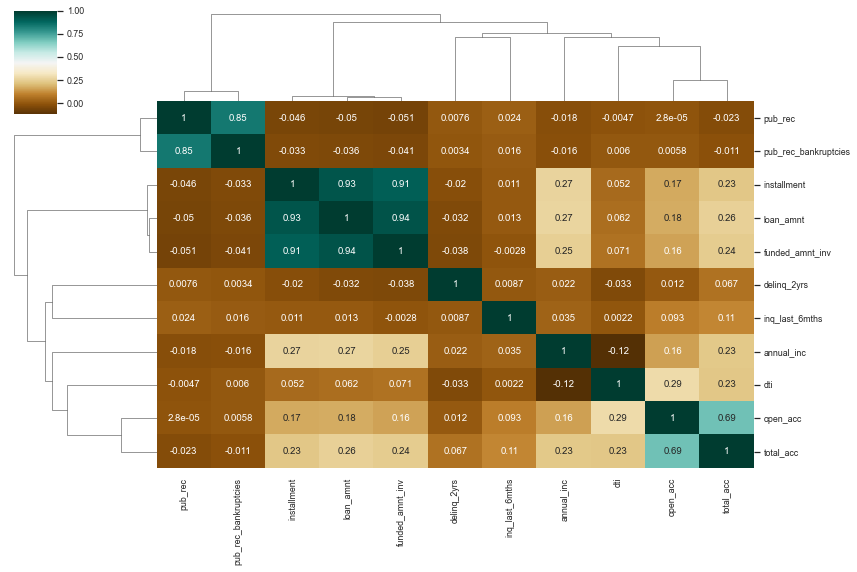

In [15]:
# remove highly correlated variables
# Bivariate Analysis - Correlation Matrix-Quantitative Variables
# Heatmap with Dendogram(clustermap) to show closeness among numerical variables.

loan_correlation = loan_df.corr()
sns.set(font_scale=0.8)
sns.clustermap(loan_correlation,annot=True,figsize=(12, 8),cmap="BrBG")
plt.show()

# Observations:
# 1. Since funded_amnt_inv, loan_amnt, installmnt are highly correlated, we can just keep one variable - loan_amount
# 2. Since pub_rec and pub_rec_bankruptcies are highly correlated, we can just keep - pub_rec_bankruptcies

In [16]:
highly_correlated_variables = ['funded_amnt_inv','installment','pub_rec']

loan_df = loan_df.drop(columns = highly_correlated_variables)
print(loan_df.shape) 

(38577, 20)


In [17]:
# Final List of columns 
loan_df.columns

Index(['loan_amnt', 'term', 'int_rate', 'grade', 'sub_grade', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'purpose', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'open_acc', 'revol_util', 'total_acc',
       'pub_rec_bankruptcies'],
      dtype='object')

### Data Imputation

In [18]:
# Checking columns that need imputations
missing_value_df = missing_value_percentage(loan_df)
missing_value_df[missing_value_df.percent_missing>0]

# Observations
# emp_length, revol_util & pub_rec_bankruptcies can be imputed 

,column_name,missing_count,percent_missing
emp_length,emp_length,1033,2.68
revol_util,revol_util,50,0.13
pub_rec_bankruptcies,pub_rec_bankruptcies,697,1.81


In [19]:
# Get distinct values
loan_df["emp_length"].value_counts()

# Observation:
# 1. We can remove symbols & "years" from the value
# 2. missing value for emp length can be replaced with 10 - mode

10+ years    8488
< 1 year     4508
2 years      4291
3 years      4012
4 years      3342
5 years      3194
1 year       3169
6 years      2168
7 years      1711
8 years      1435
9 years      1226
Name: emp_length, dtype: int64

In [20]:
loan_df.emp_length.fillna('10',inplace=True)
loan_df['emp_length']=loan_df.emp_length.str.extract('(\d+)')

In [21]:
loan_df["revol_util"].value_counts()
# Observation:
# 1. We can remove % from the values
# 2. missing value for emp length can be imputated with 0

0%        954
63%        62
0.20%      62
31.20%     57
40.70%     57
         ... 
21.92%      1
0.75%       1
8.46%       1
39.95%      1
88.48%      1
Name: revol_util, Length: 1088, dtype: int64

In [22]:
loan_df.revol_util.fillna('0',inplace=True)
loan_df['revol_util']=loan_df.revol_util.str.replace('%','')

In [23]:
loan_df["pub_rec_bankruptcies"].value_counts()
# Observation:
# 1. missing value for pub_rec_bankruptcies can be imputated with 0

0.00    36238
1.00     1637
2.00        5
Name: pub_rec_bankruptcies, dtype: int64

In [24]:
loan_df.pub_rec_bankruptcies.fillna(0,inplace=True)

### Data Conversion

In [25]:
# Running data info again
print(loan_df.info(verbose = True,show_counts = True)) # shows not null counts and data type of all columns


<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 0 to 39716
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             38577 non-null  int64  
 1   term                  38577 non-null  object 
 2   int_rate              38577 non-null  object 
 3   grade                 38577 non-null  object 
 4   sub_grade             38577 non-null  object 
 5   emp_length            38577 non-null  object 
 6   home_ownership        38577 non-null  object 
 7   annual_inc            38577 non-null  float64
 8   verification_status   38577 non-null  object 
 9   issue_d               38577 non-null  object 
 10  loan_status           38577 non-null  object 
 11  purpose               38577 non-null  object 
 12  dti                   38577 non-null  float64
 13  delinq_2yrs           38577 non-null  int64  
 14  earliest_cr_line      38577 non-null  object 
 15  inq_last_6mths     

In [26]:
# int_rate has %, so removing it
loan_df['int_rate']=loan_df.int_rate.str.replace('%','')

# converting columns from object to numeric
conversion_columns = ['int_rate','revol_util','emp_length']
loan_df[conversion_columns] = loan_df[conversion_columns].apply(pd.to_numeric)
loan_df.head()

,loan_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,revol_util,total_acc,pub_rec_bankruptcies
0,5000,36 months,10.65,B,B2,10,RENT,24000.00,Verified,Dec-11,Fully Paid,credit_card,27.65,0,Jan-85,1,3,83.70,9,0.00
1,2500,60 months,15.27,C,C4,1,RENT,30000.00,Source Verified,Dec-11,Charged Off,car,1.00,0,Apr-99,5,3,9.40,4,0.00
2,2400,36 months,15.96,C,C5,10,RENT,12252.00,Not Verified,Dec-11,Fully Paid,small_business,8.72,0,Nov-01,2,2,98.50,10,0.00
3,10000,36 months,13.49,C,C1,10,RENT,49200.00,Source Verified,Dec-11,Fully Paid,other,20.00,0,Feb-96,1,10,21.00,37,0.00
5,5000,36 months,7.90,A,A4,3,RENT,36000.00,Source Verified,Dec-11,Fully Paid,wedding,11.20,0,Nov-04,3,9,28.30,12,0.00


In [27]:
loan_df.issue_d = pd.to_datetime(loan_df.issue_d, format='%b-%y')
loan_df['issue_d_year']=loan_df['issue_d'].dt.year
loan_df['issue_d_month']=loan_df['issue_d'].dt.month

loan_df.head()

,loan_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,revol_util,total_acc,pub_rec_bankruptcies,issue_d_year,issue_d_month
0,5000,36 months,10.65,B,B2,10,RENT,24000.00,Verified,2011-12-01,Fully Paid,credit_card,27.65,0,Jan-85,1,3,83.70,9,0.00,2011,12
1,2500,60 months,15.27,C,C4,1,RENT,30000.00,Source Verified,2011-12-01,Charged Off,car,1.00,0,Apr-99,5,3,9.40,4,0.00,2011,12
2,2400,36 months,15.96,C,C5,10,RENT,12252.00,Not Verified,2011-12-01,Fully Paid,small_business,8.72,0,Nov-01,2,2,98.50,10,0.00,2011,12
3,10000,36 months,13.49,C,C1,10,RENT,49200.00,Source Verified,2011-12-01,Fully Paid,other,20.00,0,Feb-96,1,10,21.00,37,0.00,2011,12
5,5000,36 months,7.90,A,A4,3,RENT,36000.00,Source Verified,2011-12-01,Fully Paid,wedding,11.20,0,Nov-04,3,9,28.30,12,0.00,2011,12


## Data Analysis

In [28]:
# Checking summary statistics again - kind of Univariate analysis
loan_df.describe(include='all') # provide summary statistics of all columns

,loan_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,revol_util,total_acc,pub_rec_bankruptcies,issue_d_year,issue_d_month
count,38577.00,38577,38577.00,38577,38577,38577.00,38577,38577.00,38577,38577,38577,38577,38577.00,38577.00,38577,38577.00,38577.00,38577.00,38577.00,38577.00,38577.00,38577.00
unique,NaN,2,NaN,7,35,NaN,5,NaN,3,55,2,14,NaN,NaN,524,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,36 months,NaN,B,A4,NaN,RENT,NaN,Not Verified,2011-11-01 00:00:00,Fully Paid,debt_consolidation,NaN,NaN,Oct-99,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,29096,NaN,11675,2873,NaN,18480,NaN,16694,2062,32950,18055,NaN,NaN,360,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-06-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,11047.03,NaN,11.93,NaN,NaN,5.19,NaN,68777.97,NaN,NaN,NaN,NaN,13.27,0.15,NaN,0.87,9.28,48.64,22.05,0.04,2010.31,7.11
std,7348.44,NaN,3.69,NaN,NaN,3.45,NaN,64218.68,NaN,NaN,NaN,NaN,6.67,0.49,NaN,1.07,4.40,28.40,11.43,0.20,0.88,3.41
min,500.00,NaN,5.42,NaN,NaN,1.00,NaN,4000.00,NaN,NaN,NaN,NaN,0.00,0.00,NaN,0.00,2.00,0.00,2.00,0.00,2007.00,1.00
25%,5300.00,NaN,8.94,NaN,NaN,2.00,NaN,40000.00,NaN,NaN,NaN,NaN,8.13,0.00,NaN,0.00,6.00,25.10,13.00,0.00,2010.00,4.00


Fully Paid    85.41
Charged Off   14.59
Name: loan_status, dtype: float64


<AxesSubplot:xlabel='loan_status', ylabel='count'>

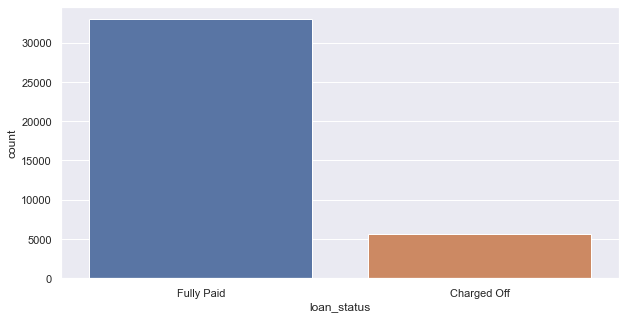

In [29]:
# Checking the distribution of loan status 
sns.set(rc={'figure.figsize':(10,5)})
print(loan_df["loan_status"].value_counts()*100/len(loan_df))

sns.countplot(x = 'loan_status', data = loan_df)

In [30]:
# Checking summary statistics again 
loan_df.describe(include='all') # provide summary statistics of all columns

# Observations:
# 1. Looking at the summary statistics looks like the almost all fields are outlier free except annual inc - difference between 75% to max is way too high

,loan_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,revol_util,total_acc,pub_rec_bankruptcies,issue_d_year,issue_d_month
count,38577.00,38577,38577.00,38577,38577,38577.00,38577,38577.00,38577,38577,38577,38577,38577.00,38577.00,38577,38577.00,38577.00,38577.00,38577.00,38577.00,38577.00,38577.00
unique,NaN,2,NaN,7,35,NaN,5,NaN,3,55,2,14,NaN,NaN,524,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,36 months,NaN,B,A4,NaN,RENT,NaN,Not Verified,2011-11-01 00:00:00,Fully Paid,debt_consolidation,NaN,NaN,Oct-99,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,29096,NaN,11675,2873,NaN,18480,NaN,16694,2062,32950,18055,NaN,NaN,360,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-06-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,11047.03,NaN,11.93,NaN,NaN,5.19,NaN,68777.97,NaN,NaN,NaN,NaN,13.27,0.15,NaN,0.87,9.28,48.64,22.05,0.04,2010.31,7.11
std,7348.44,NaN,3.69,NaN,NaN,3.45,NaN,64218.68,NaN,NaN,NaN,NaN,6.67,0.49,NaN,1.07,4.40,28.40,11.43,0.20,0.88,3.41
min,500.00,NaN,5.42,NaN,NaN,1.00,NaN,4000.00,NaN,NaN,NaN,NaN,0.00,0.00,NaN,0.00,2.00,0.00,2.00,0.00,2007.00,1.00
25%,5300.00,NaN,8.94,NaN,NaN,2.00,NaN,40000.00,NaN,NaN,NaN,NaN,8.13,0.00,NaN,0.00,6.00,25.10,13.00,0.00,2010.00,4.00


<AxesSubplot:xlabel='loan_amnt'>

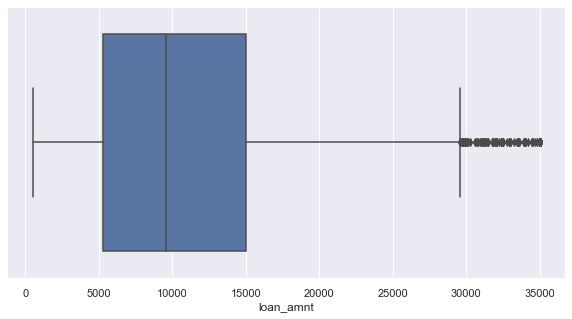

In [31]:
variables_to_check_for_outliers = ['loan_amnt','funded_amnt_inv','annual_inc','dti']

sns.boxplot(loan_df['loan_amnt'])

<AxesSubplot:xlabel='annual_inc'>

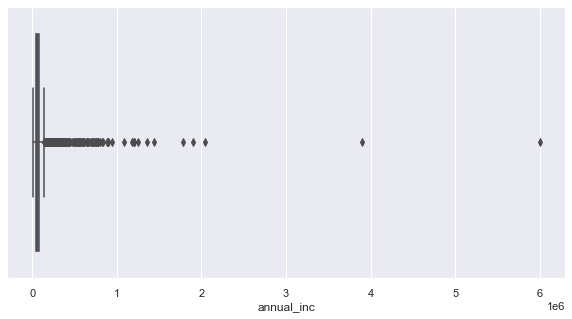

In [32]:
sns.boxplot(loan_df['annual_inc'])

# Observations:
# 1. Looks like annual inc has outliers


<AxesSubplot:xlabel='dti'>

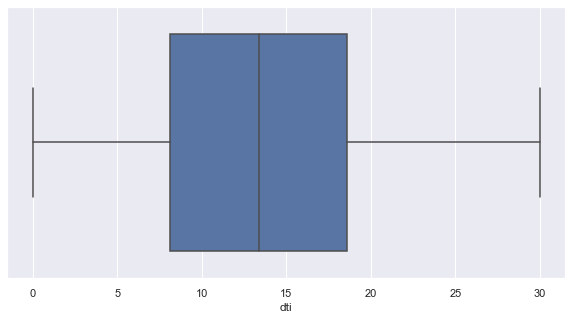

In [33]:
sns.boxplot(loan_df['dti'])


In [34]:
# Removing outliers from annual inc
quantile_info = loan_df.annual_inc.quantile([0.5, 0.75,0.90, 0.95, 0.97,0.98, 0.99])
quantile_info           

0.50    58868.00
0.75    82000.00
0.90   115000.00
0.95   140004.00
0.97   165000.00
0.98   187000.00
0.99   234144.00
Name: annual_inc, dtype: float64

<AxesSubplot:xlabel='annual_inc'>

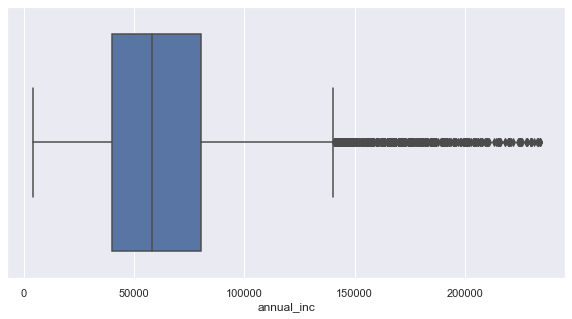

In [35]:
# Removing only 99 and checking
loan_df = loan_df[loan_df.annual_inc <= loan_df['annual_inc'].quantile(0.99)]
sns.boxplot(loan_df.annual_inc)

# Observations:
# 1. Still we see a lot of outliers

<AxesSubplot:xlabel='annual_inc'>

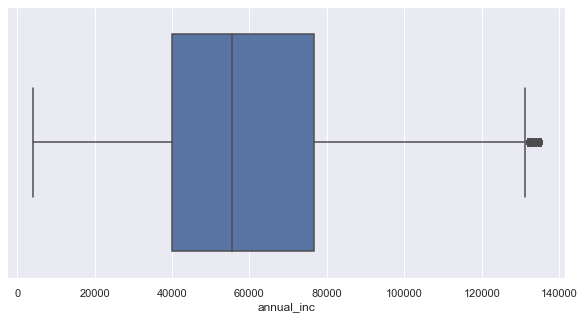

In [36]:
# Removing only 95 and checking
loan_df = loan_df[loan_df.annual_inc <= loan_df['annual_inc'].quantile(0.95)]
sns.boxplot(loan_df.annual_inc)

# Observations:
# 1. This looks a lot better and we dont need to remove additional data further

In [37]:
loan_df['int_rate_groups'] = pd.cut(loan_df['int_rate'], bins=5,precision =0,labels=['5%-9%','9%-13%','13%-17%','17%-21%','21%-24%'])
loan_df['open_acc_groups'] = pd.cut(loan_df['open_acc'],bins = 5,precision =0,labels=['2-10','10-19','19-27','27-36','36-44'])
loan_df['revol_util_groups'] = pd.cut(loan_df['revol_util'], bins=5,precision =0,labels=['0-20','20-40','40-60','60-80','80-100'])
loan_df['total_acc_groups'] = pd.cut(loan_df['total_acc'], bins=5,precision =0,labels=['2-20','20-37','37-55','55-74','74-90'])
loan_df['annual_inc_groups'] = pd.cut(loan_df['annual_inc'], bins=5,precision =0,labels =['3k-31k','31k-58k','58k-85k','85k-112k','112k-140k'])
loan_df['loan_amnt_groups'] = pd.cut(loan_df['loan_amnt'], bins=7,precision =0,labels=['0-5k','5k-10k','10k-15k','15k-20k','20k-25k','25k-30k','30k-35k'])
loan_df['dti_groups'] = pd.cut(loan_df['dti'], bins=5,precision =0,labels=['0-6','6-12','12-18','18-24','24-30'])
loan_df.head()


,loan_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,revol_util,total_acc,pub_rec_bankruptcies,issue_d_year,issue_d_month,int_rate_groups,open_acc_groups,revol_util_groups,total_acc_groups,annual_inc_groups,loan_amnt_groups,dti_groups
0,5000,36 months,10.65,B,B2,10,RENT,24000.00,Verified,2011-12-01,Fully Paid,credit_card,27.65,0,Jan-85,1,3,83.70,9,0.00,2011,12,9%-13%,2-10,80-100,2-20,3k-31k,0-5k,24-30
1,2500,60 months,15.27,C,C4,1,RENT,30000.00,Source Verified,2011-12-01,Charged Off,car,1.00,0,Apr-99,5,3,9.40,4,0.00,2011,12,13%-17%,2-10,0-20,2-20,3k-31k,0-5k,0-6
2,2400,36 months,15.96,C,C5,10,RENT,12252.00,Not Verified,2011-12-01,Fully Paid,small_business,8.72,0,Nov-01,2,2,98.50,10,0.00,2011,12,13%-17%,2-10,80-100,2-20,3k-31k,0-5k,6-12
3,10000,36 months,13.49,C,C1,10,RENT,49200.00,Source Verified,2011-12-01,Fully Paid,other,20.00,0,Feb-96,1,10,21.00,37,0.00,2011,12,13%-17%,2-10,20-40,20-37,31k-58k,5k-10k,18-24
5,5000,36 months,7.90,A,A4,3,RENT,36000.00,Source Verified,2011-12-01,Fully Paid,wedding,11.20,0,Nov-04,3,9,28.30,12,0.00,2011,12,5%-9%,2-10,20-40,2-20,31k-58k,0-5k,6-12


In [38]:
loan_df.columns

# Index(['loan_amnt', 'term', 'int_rate', 'grade', 'sub_grade', 'emp_length',
#        'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
#        'loan_status', 'purpose', 'dti', 'delinq_2yrs', 'earliest_cr_line',
#        'inq_last_6mths', 'open_acc', 'revol_util', 'total_acc',
#        'pub_rec_bankruptcies', 'issue_d_year', 'issue_d_month',
#        'int_rate_groups', 'open_acc_groups', 'revol_util_groups',
#        'total_acc_groups', 'annual_inc_groups', 'loan_amnt_groups',
#        'dti_groups'],
#       dtype='object')

Index(['loan_amnt', 'term', 'int_rate', 'grade', 'sub_grade', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'purpose', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'open_acc', 'revol_util', 'total_acc',
       'pub_rec_bankruptcies', 'issue_d_year', 'issue_d_month',
       'int_rate_groups', 'open_acc_groups', 'revol_util_groups',
       'total_acc_groups', 'annual_inc_groups', 'loan_amnt_groups',
       'dti_groups'],
      dtype='object')

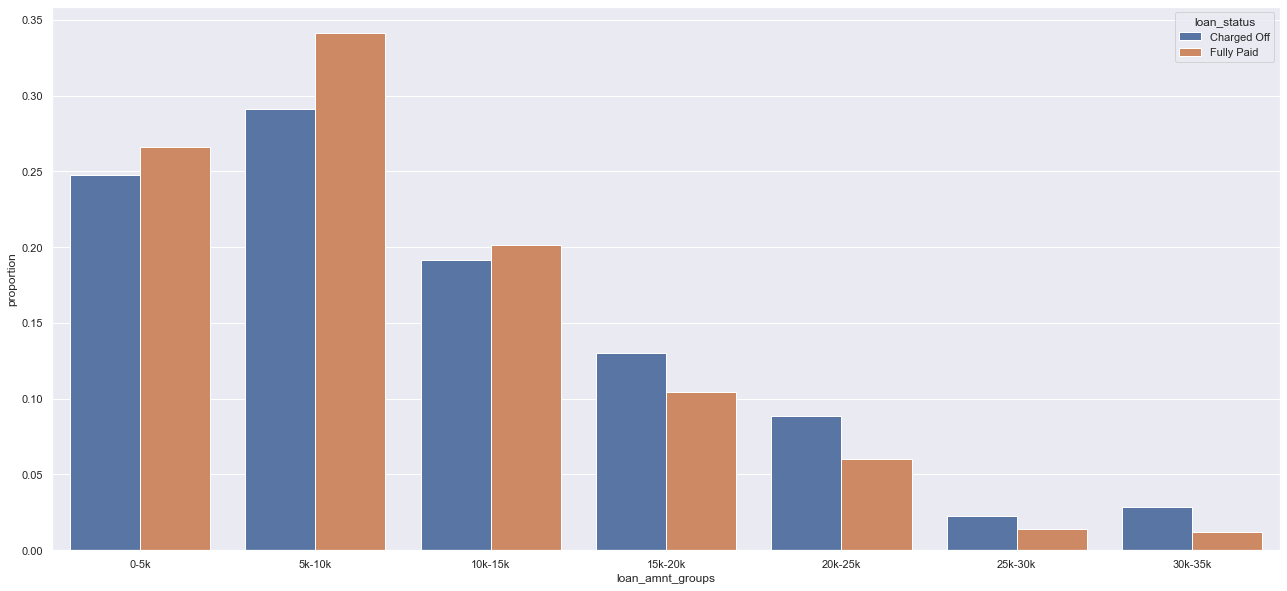

In [39]:
sns.set(rc={'figure.figsize':(22,10)})
plot_with_target_variable(loan_df, "loan_amnt_groups", "loan_status")
# Observations
# With increase in loan amount the proportion of defaulters is also increasing

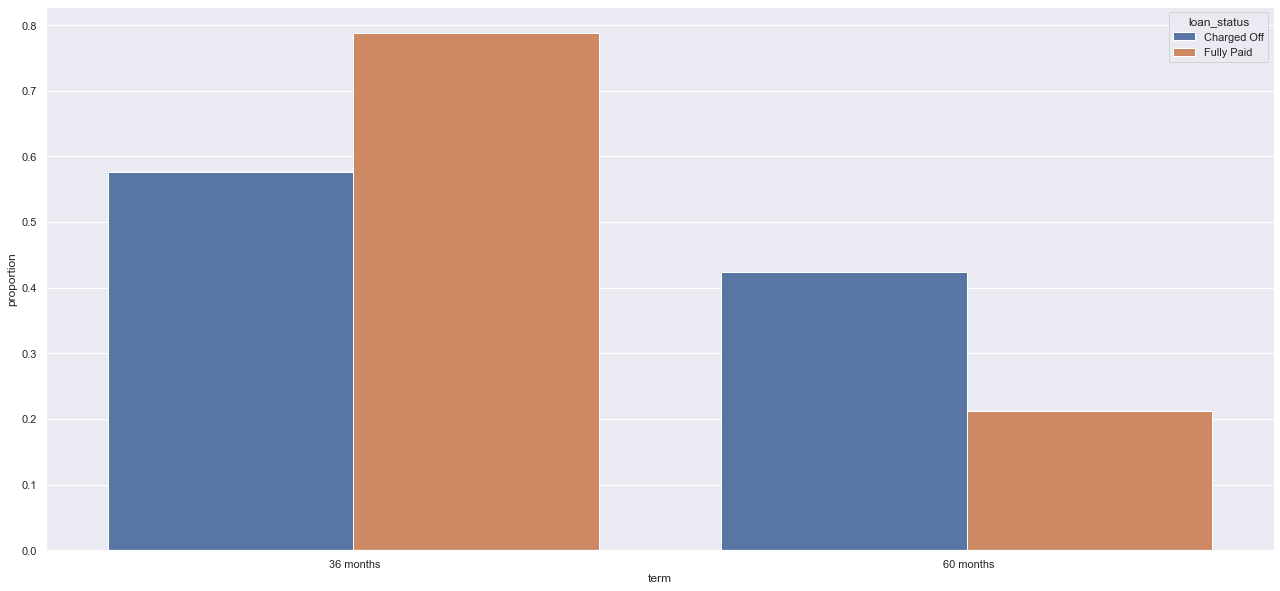

In [40]:
plot_with_target_variable(loan_df, "term", "loan_status")
# Observations
# With increase in term the default proportion is also increasing

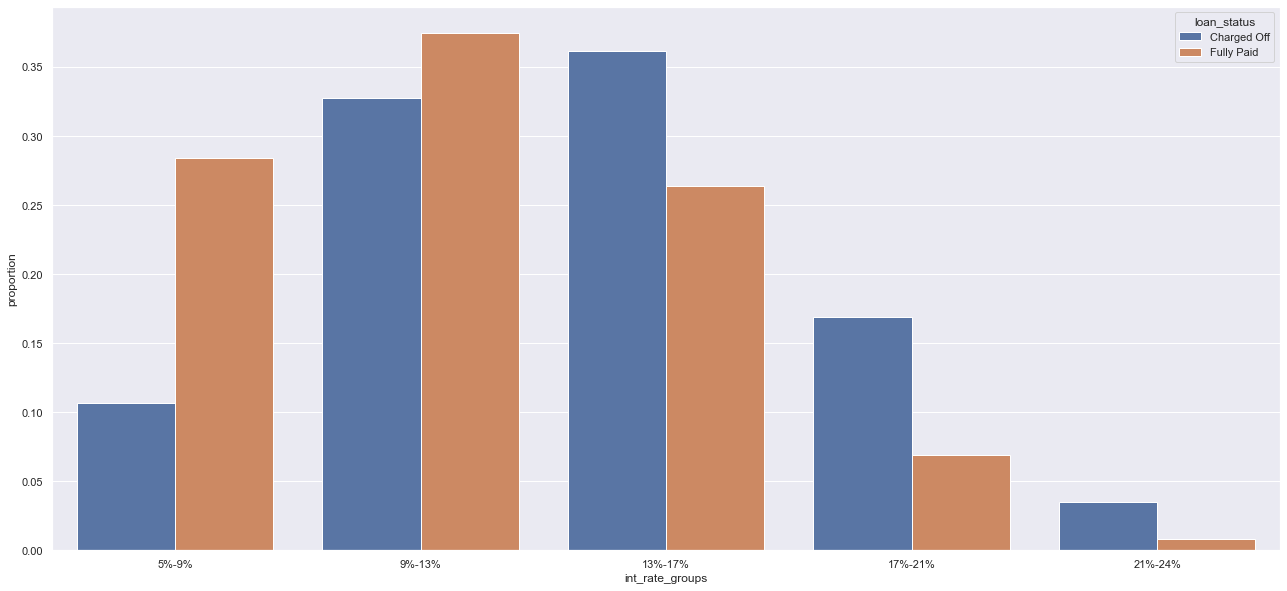

In [41]:
plot_with_target_variable(loan_df, "int_rate_groups", "loan_status")

# Observations:
# 1. It clearly shows the inverse relationship with loan repayment & interest rate - people pay off loans when the interest is low

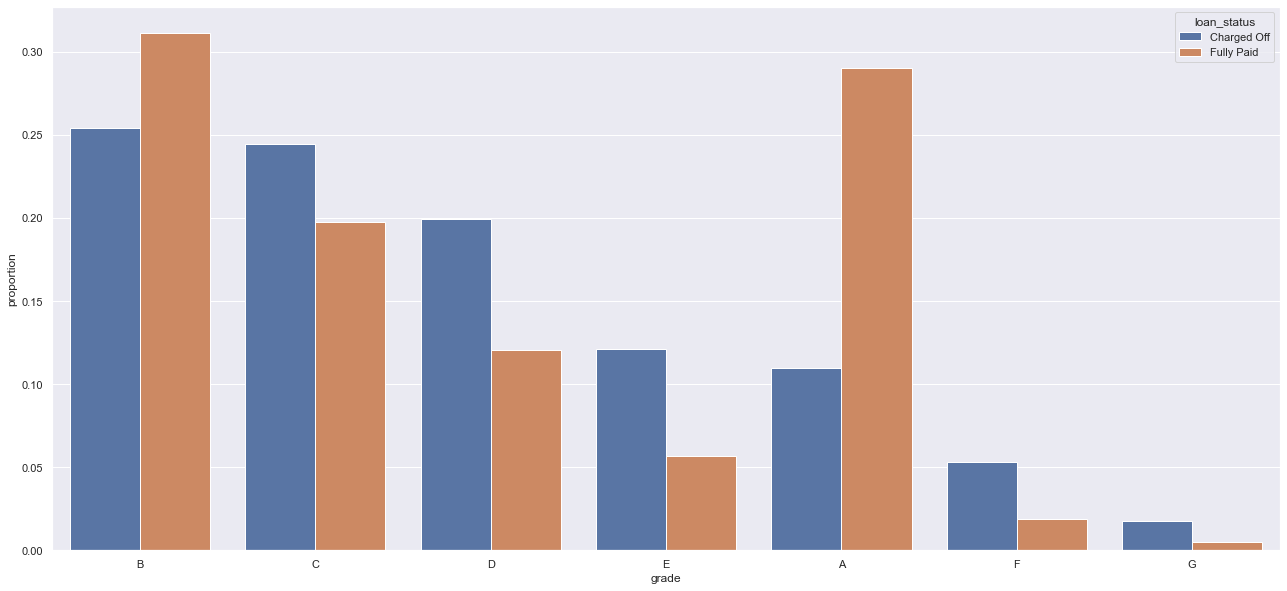

In [42]:
plot_with_target_variable(loan_df, "grade", "loan_status")

# Observations:
# 1. People with Grade A has significantly higher proportion of non-defaulters
# 2. With reducing grades the proportion of defaulters is increasing

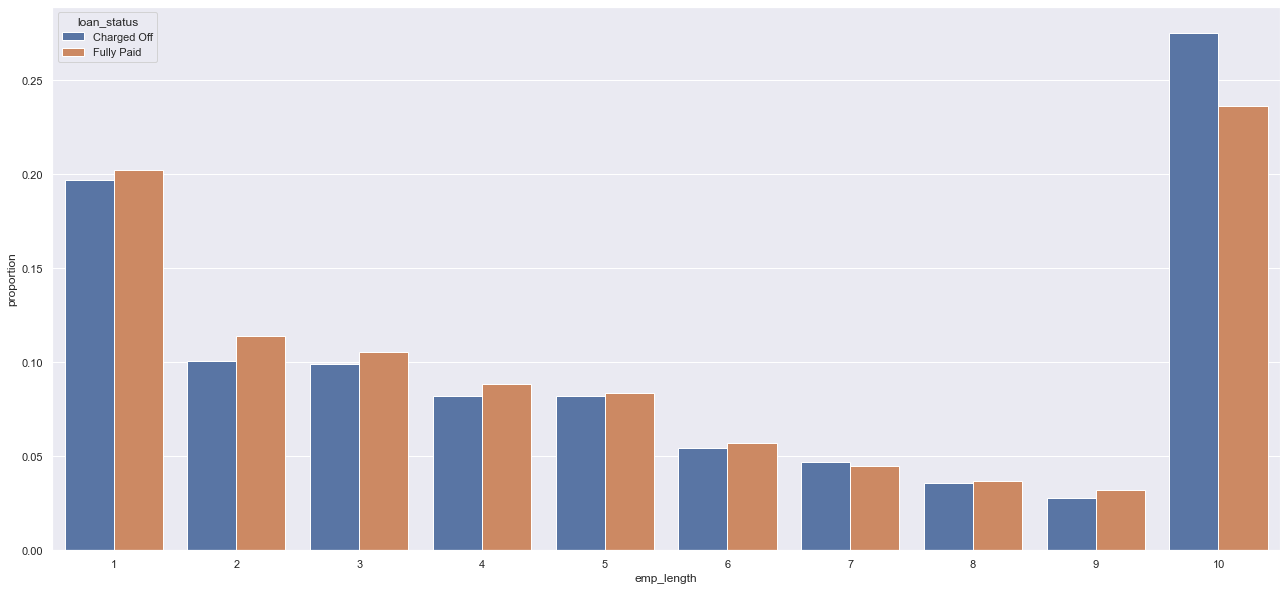

In [43]:
plot_with_target_variable(loan_df, "emp_length", "loan_status")
# Observations:
# 1. EMployee with 10+ yrs exp have high default rate than others


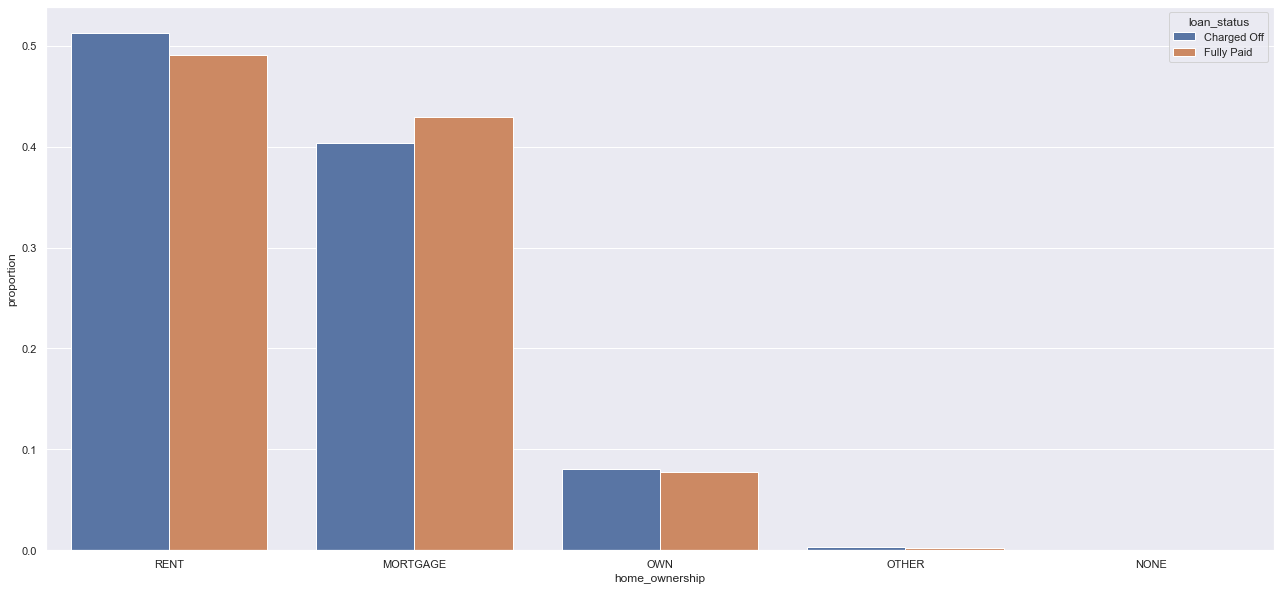

In [44]:
plot_with_target_variable(loan_df, "home_ownership", "loan_status")
# Customers with rent have slightly higher proportion of default ratio 

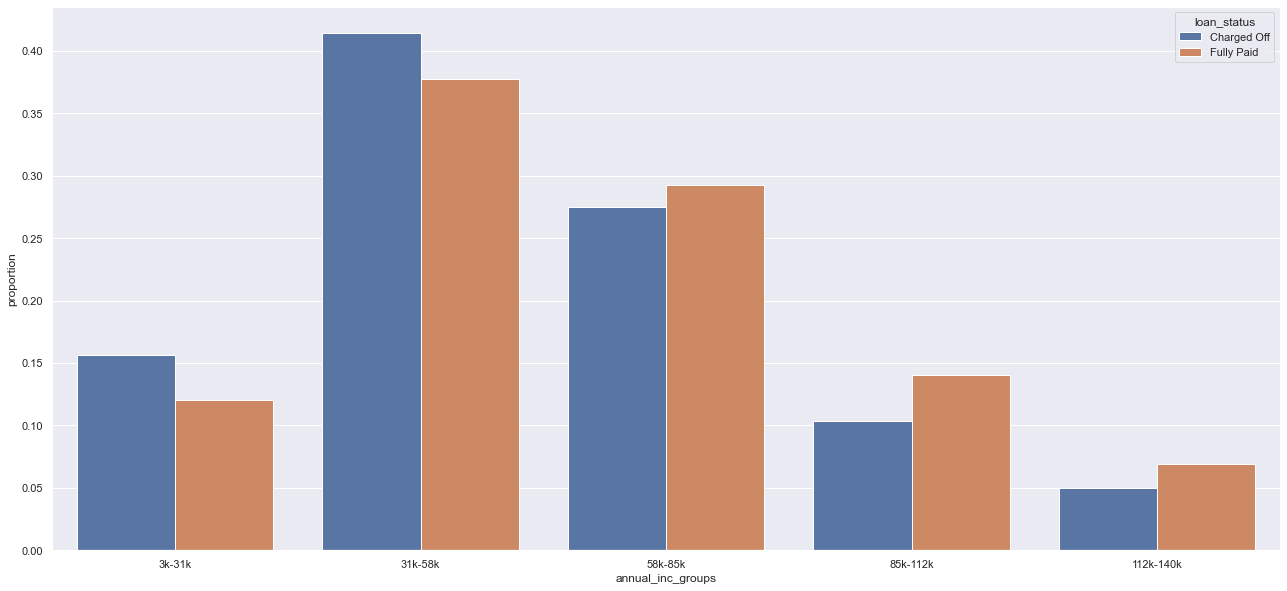

In [45]:
# Checking annual_inc_groups with loan_status

plot_with_target_variable(loan_df, "annual_inc_groups", "loan_status")

# Observations:
# 1. With increase in salary levels the default rate is reducing

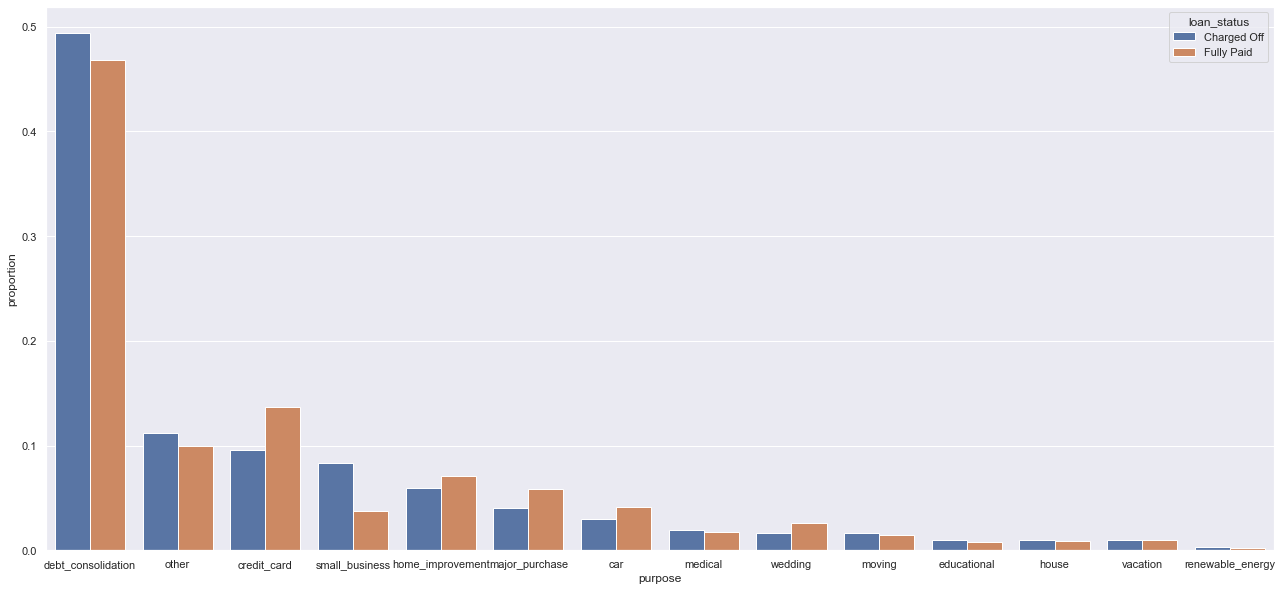

In [46]:
# Checking purpose with loan_status
plot_with_target_variable(loan_df, "purpose", "loan_status")

# Observations:
# 1. It clearly shows that loans taken for debt consolidation, other & small business has a higher chance to default
# 2. It also shows that loans taken for credit card, home improvement, car and wedding has lower chance to default


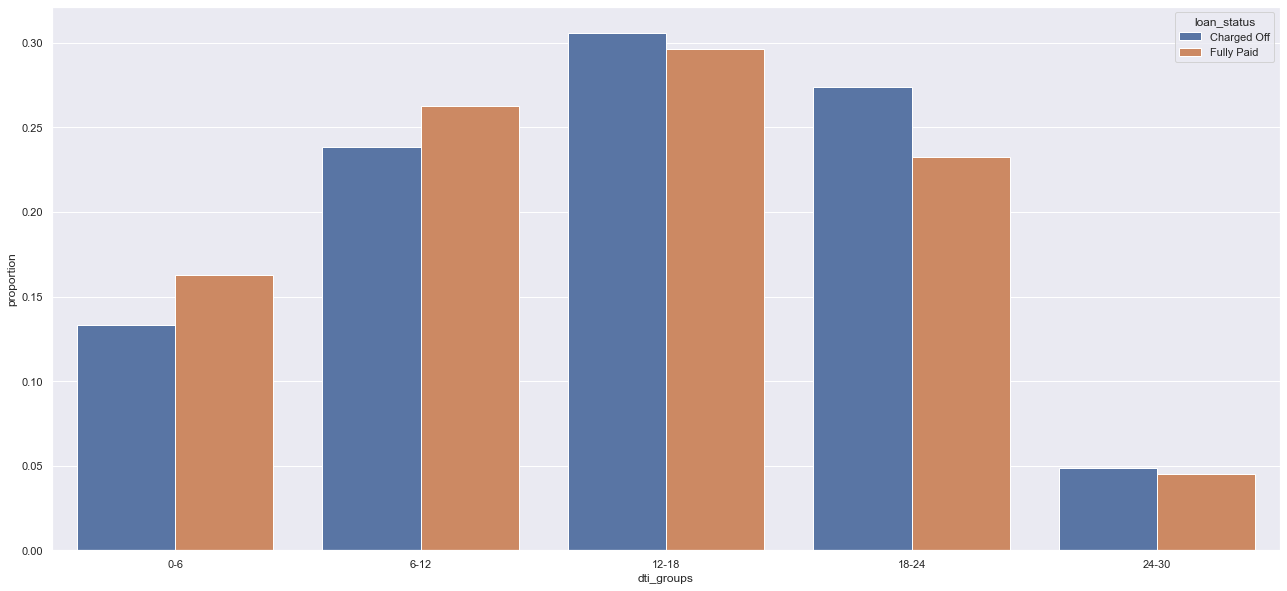

In [47]:
plot_with_target_variable(loan_df, "dti_groups", "loan_status")

# With  increasing DTI the default proportion is also increasing

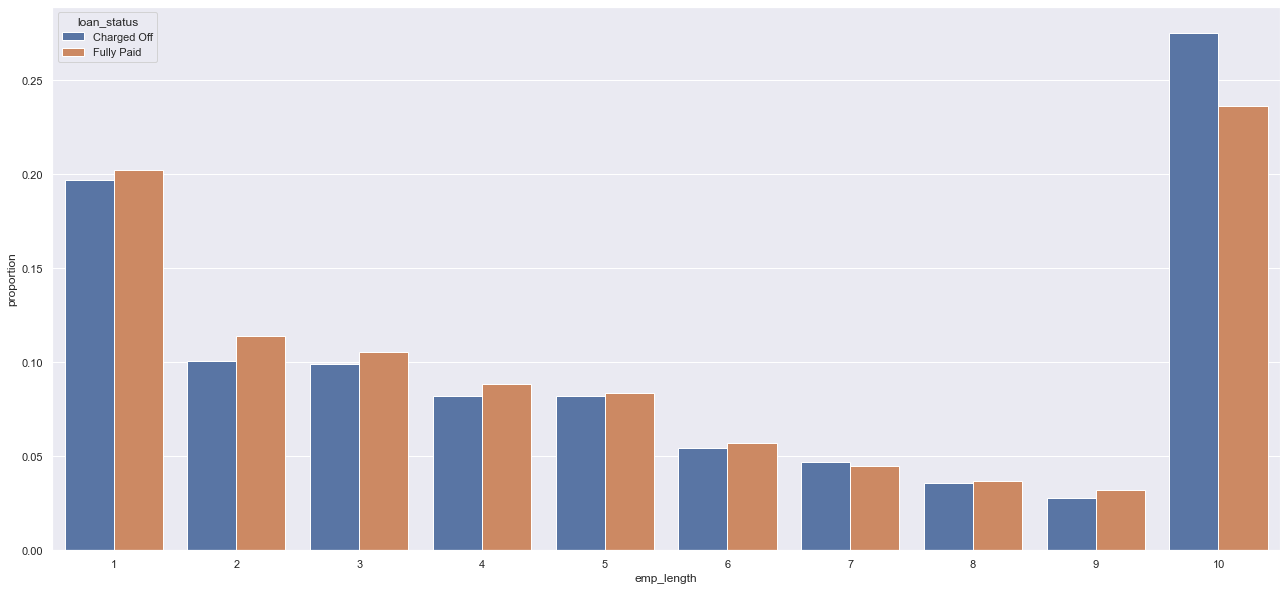

In [48]:
plot_with_target_variable(loan_df, "emp_length", "loan_status")

# employee length with 10+ yrs - higher default proportion

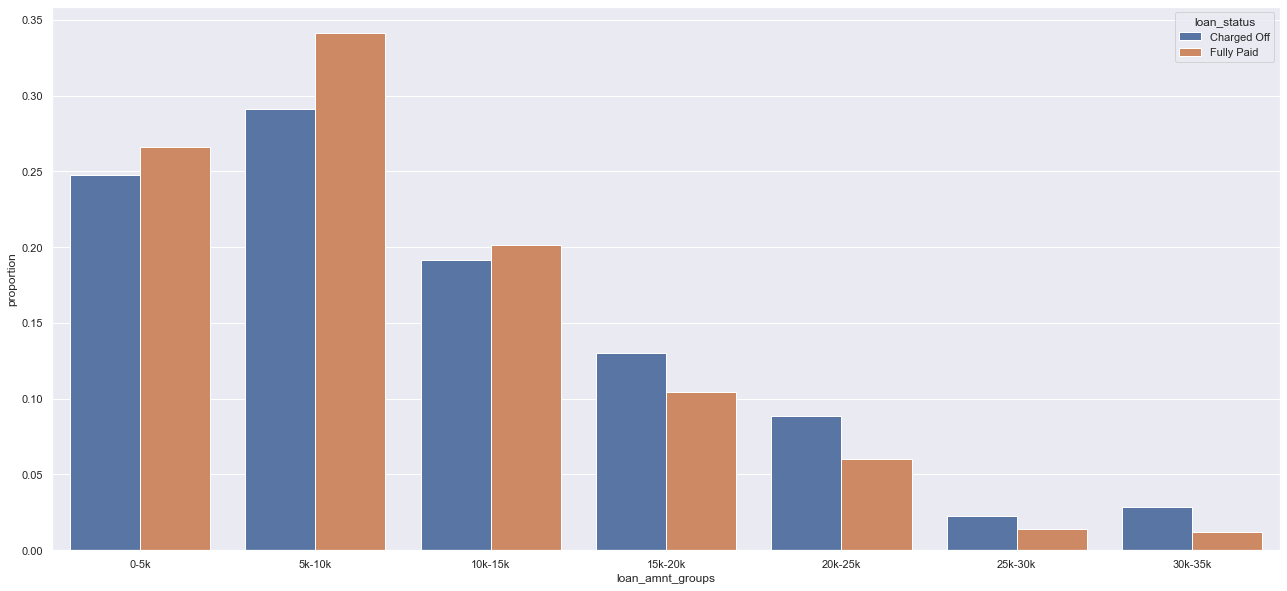

In [49]:
plot_with_target_variable(loan_df, "loan_amnt_groups", "loan_status")

# with increasing loan the default proportion is increasing

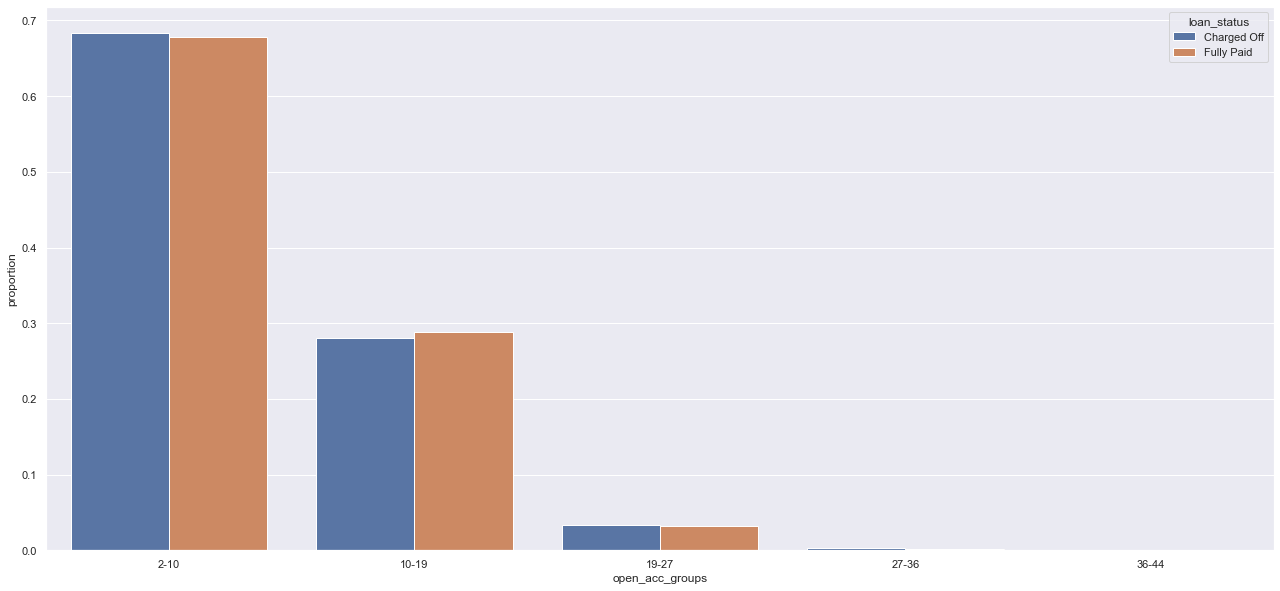

In [50]:
plot_with_target_variable(loan_df, "open_acc_groups", "loan_status")
# Observation
# 1. No significant difference

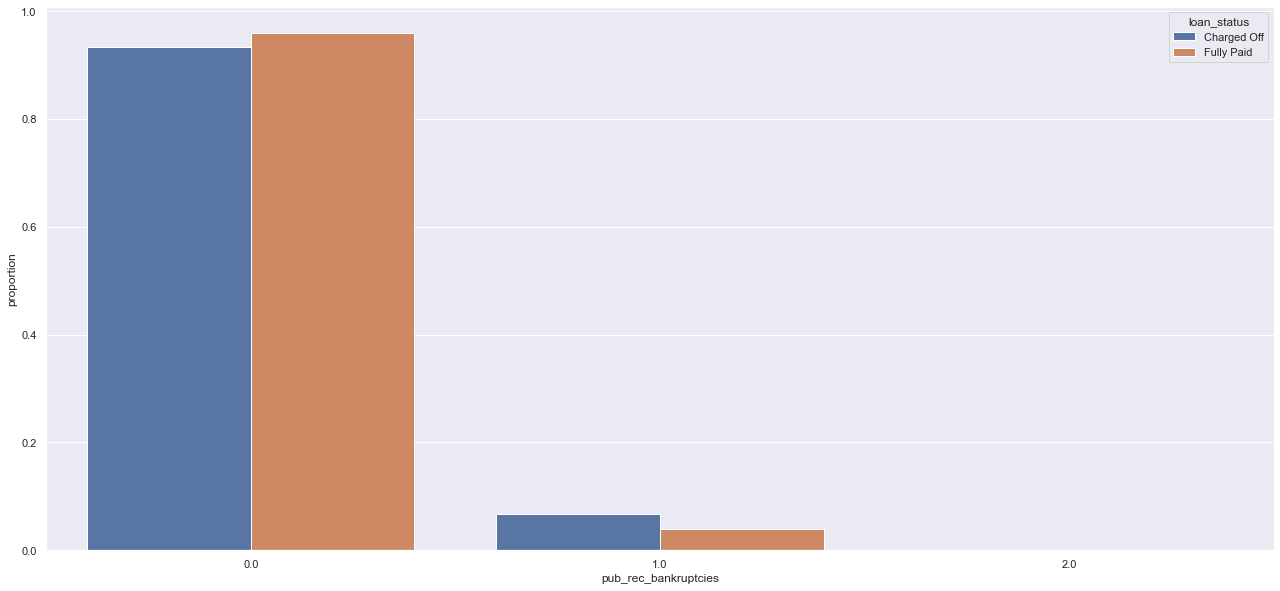

In [51]:
plot_with_target_variable(loan_df, "pub_rec_bankruptcies", "loan_status")

# Observation
# 1. Customers with a pub_rec_banckrupcies has higher ratio of defaulting

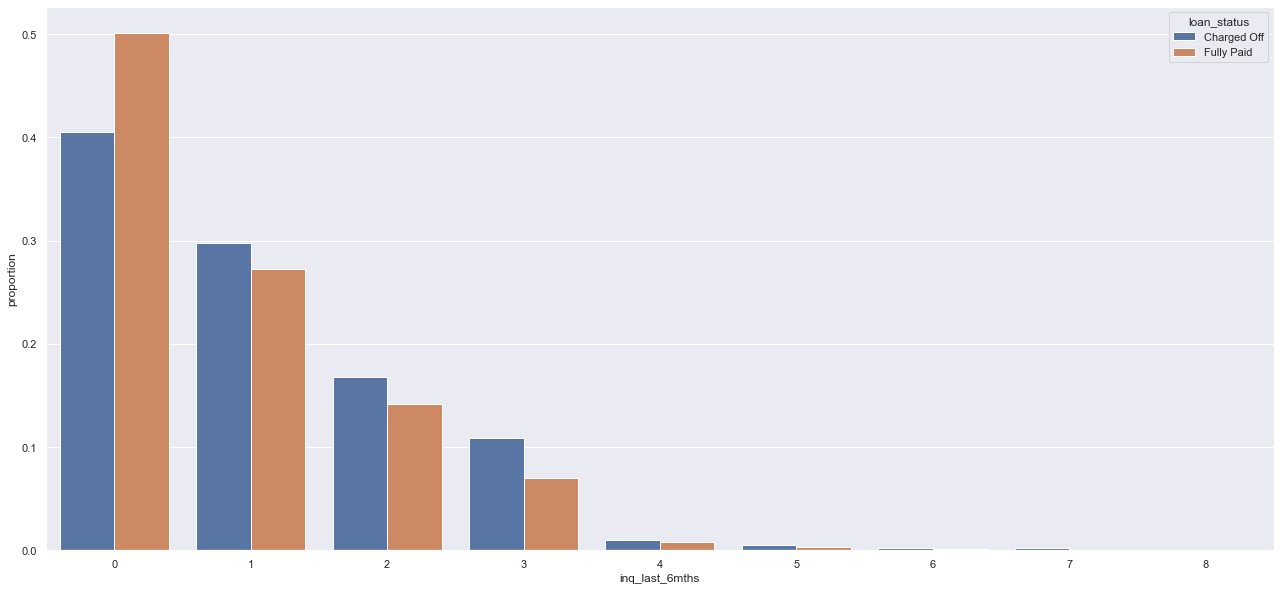

In [52]:
plot_with_target_variable(loan_df, "inq_last_6mths", "loan_status")
# Observations
# 1. Customers with less enquiries has better non default ratio than others

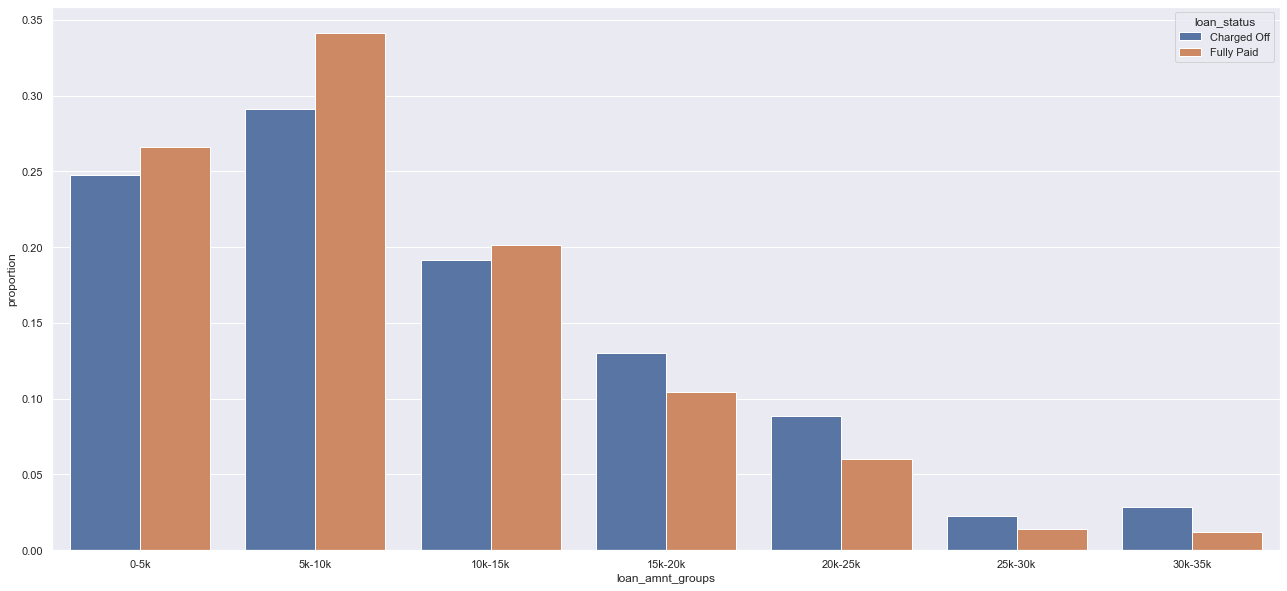

In [53]:
plot_with_target_variable(loan_df, "loan_amnt_groups", "loan_status")
# Observations
# With increase in loan amount the proportion of defaulters is also increasing

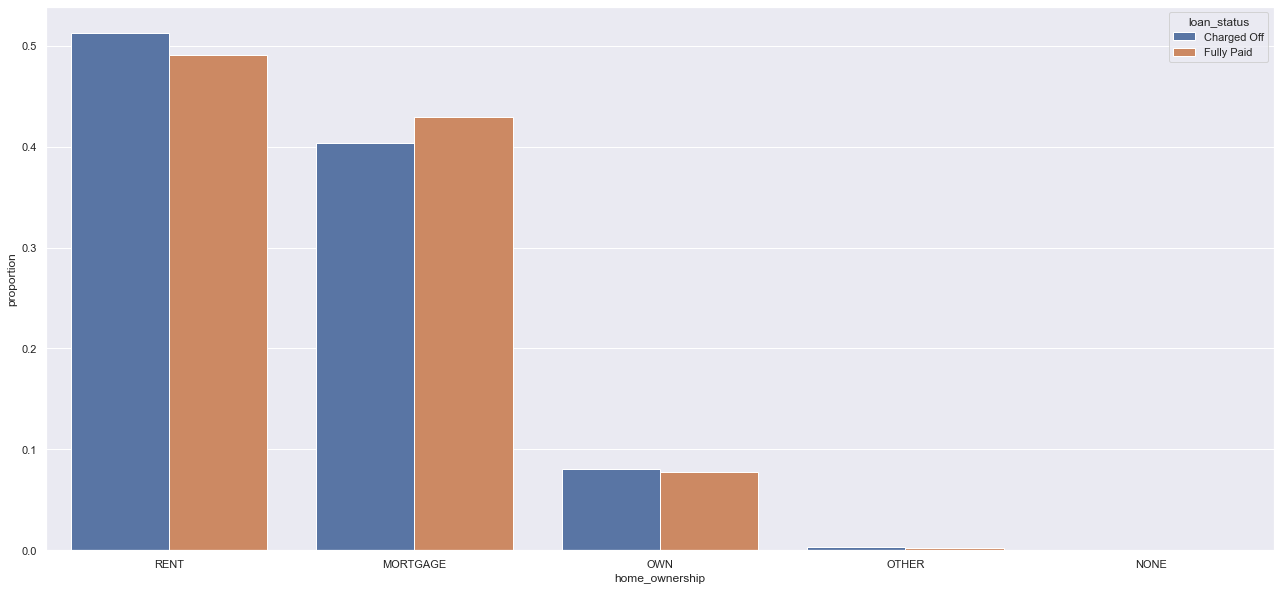

In [54]:
plot_with_target_variable(loan_df, "home_ownership", "loan_status")
# Loans with higher duration has more chances to default

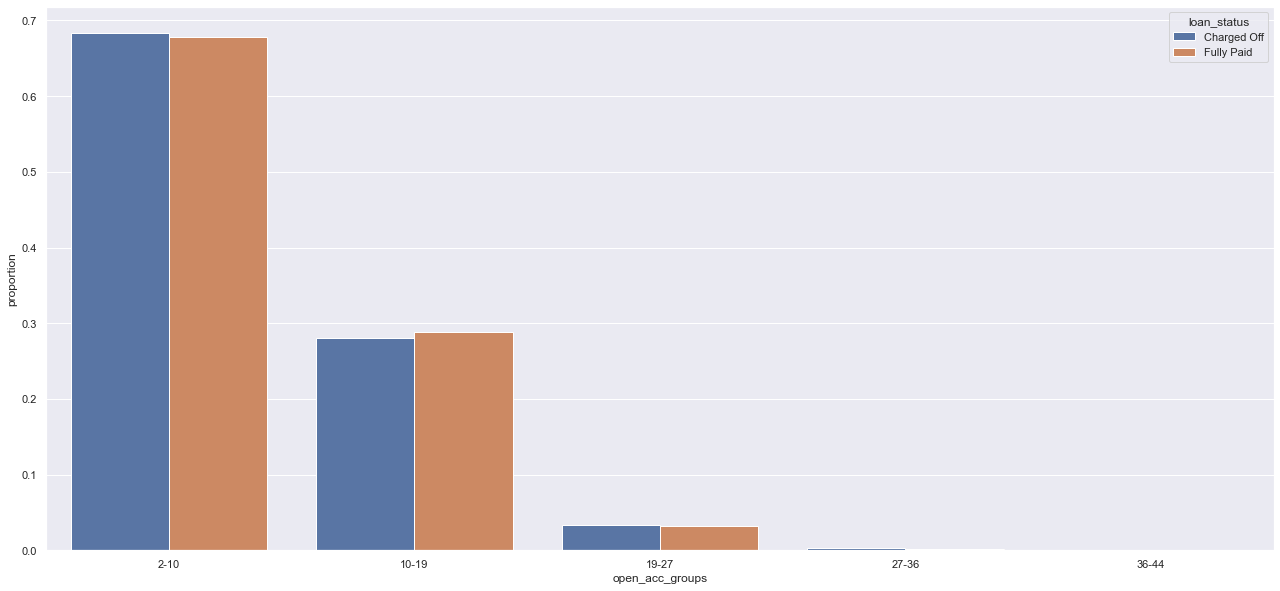

In [55]:
# Checking open_acc_groups with loan_status

plot_with_target_variable(loan_df, "open_acc_groups", "loan_status")

# Observations:
# 1. No significant difference here

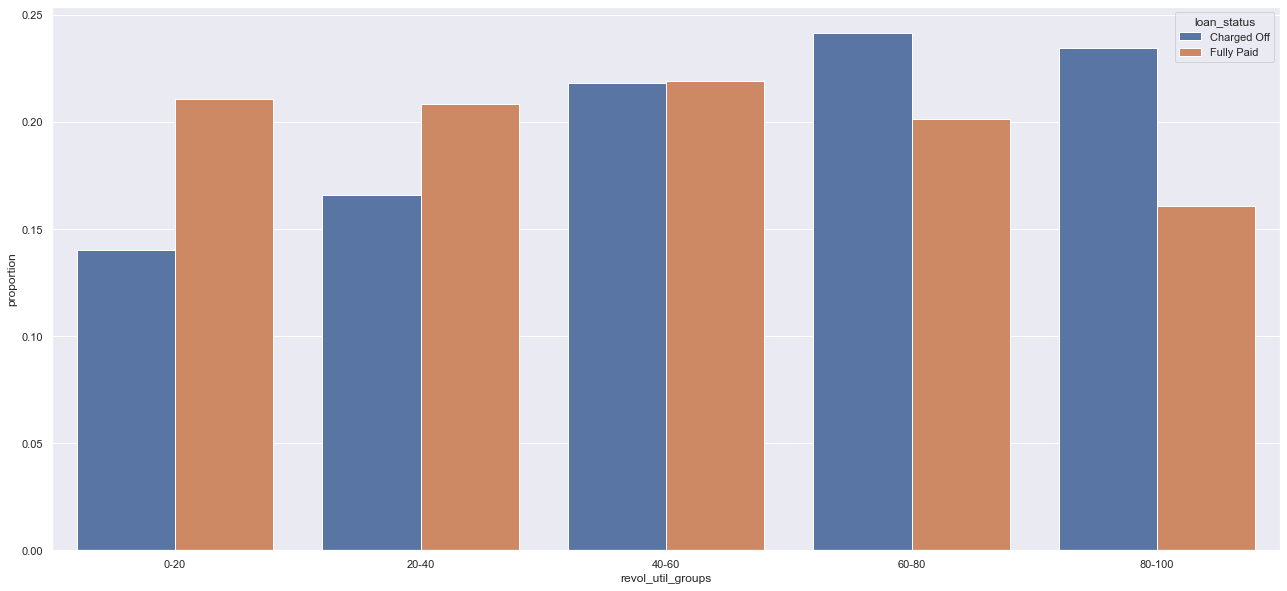

In [56]:
# Checking revol_util_groups with loan_status

plot_with_target_variable(loan_df, "revol_util_groups", "loan_status")

# Observations:
# 1. with increase in revol util there is an increase in customers defaulting

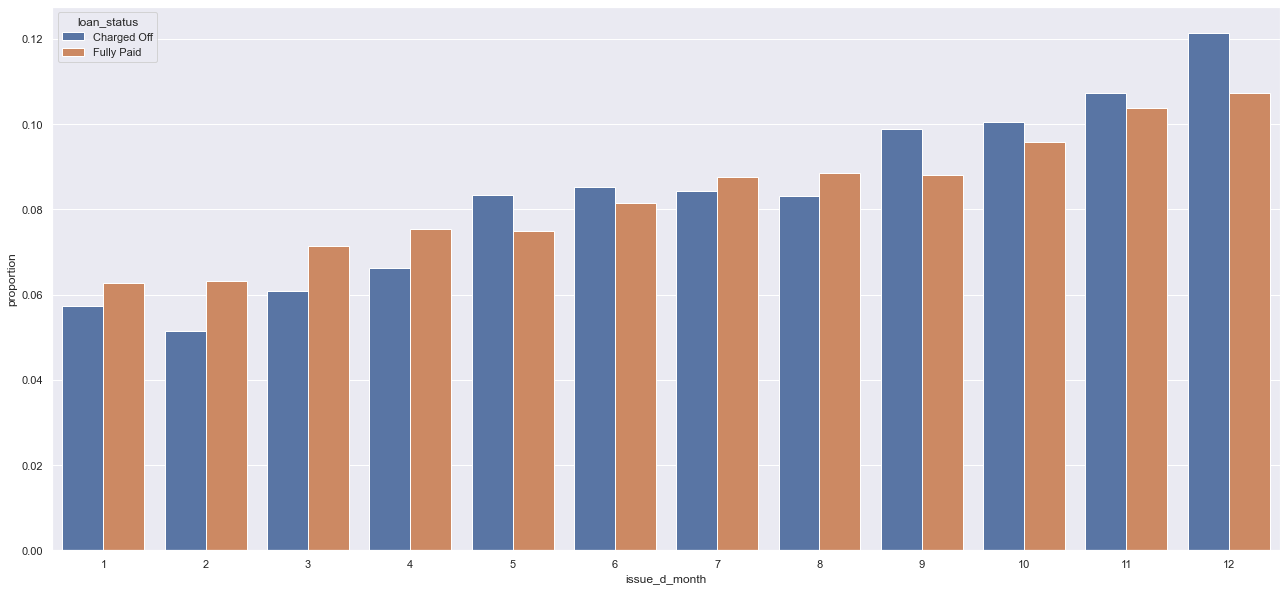

In [57]:
# Checking revol_util_groups with loan_status

plot_with_target_variable(loan_df, "issue_d_month", "loan_status")

# Observations:
# 1. The difference in proportion of defaulters and non defaulters seems to be higher in the month of December - elsewhere it seems to be fine
# 2. Also, with each month, loan disbursed/approved is in increasing trend - maybe because fo year end targets, we see executives pushing for customers to take loans

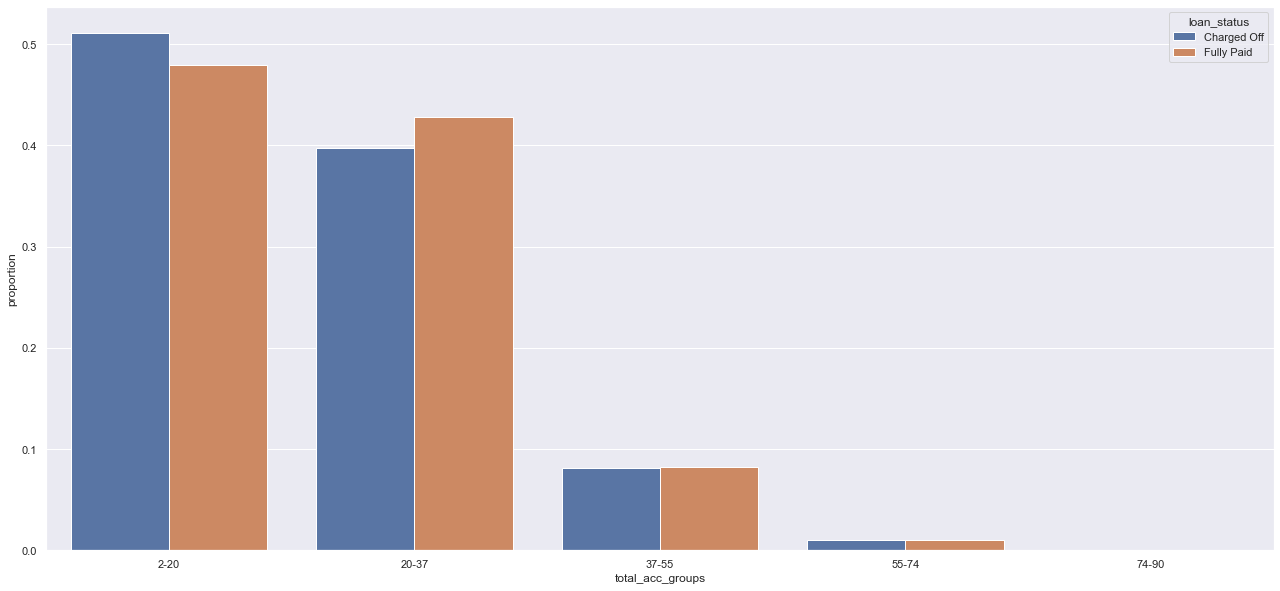

In [58]:
# Checking total_acc_groups with loan_status

plot_with_target_variable(loan_df, "total_acc_groups", "loan_status")

# Observations:
# 1. Not much difference 